# VIDEO CREATION

In [32]:
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from id_label import *
from feature_extraction import *
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

svc = joblib.load('svc.pkl') 
X_scaler = joblib.load('X_scaler.pkl')

ima = mpimg.imread('C:\\Users\\chrzanowski.dm\\Documents\\carnd\p5\\CarND-Vehicle-Detection\\test_images\\test4.jpg')

a_heatmap = np.zeros_like(ima[:,:,0]).astype(np.float)

#Global variable for summing heatmaps over last 10 frames
heatmap_array = [a_heatmap, a_heatmap, a_heatmap, a_heatmap, a_heatmap, a_heatmap, a_heatmap, a_heatmap, a_heatmap, a_heatmap]

def process_frame_subsample(image):
    
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, 720] # Min and max in y to search in slide_window()
    conv='RGB2HLS'
    
    hot_windows = []

    ystart = 380
    ystop = 550
    scale_one = 1.0
    cells_per_step = 1
    hot_windows.extend(find_cars(image, ystart, ystop, scale_one, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
    ystart = 380
    ystop = 600
    scale_two = 1.5
    cells_per_step = 3
    hot_windows.extend(find_cars(image, ystart, ystop, scale_two, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
    ystart = 350
    ystop = 600
    scale_three = 2.5
    cells_per_step = 3
    hot_windows.extend(find_cars(image, ystart, ystop, scale_three, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
#     ystart = 450
#     ystop = 720
#     scale_four = 4.0
#     hot_windows.extend(find_cars(image, ystart, ystop, scale_four, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat, 2)
    
    #shift down elements in array
    for i in range (len(heatmap_array)-1): 
        heatmap_array[i] = heatmap_array[i+1]
        
    #append "heat" to end of heatmap array
    heatmap_array[len(heatmap_array)-1] = heat
    
    all_heat = sum(heatmap_array)
        

    # Apply threshold to help remove false positives
    all_heat = apply_threshold(all_heat,7)

    # Visualize the heatmap when displaying    
    #all_heat = all_heat*30
    heatmap = np.clip(all_heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

basic_output = 'project_video_outputx.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
basic_clip = clip1.fl_image(process_frame_subsample) #NOTE: this function expects color images!!
%time basic_clip.write_videofile(basic_output, audio=False)

[MoviePy] >>>> Building video project_video_outputx.mp4
[MoviePy] Writing video project_video_outputx.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

KeyboardInterrupt: 

# DEMONSTRATE WINDOWS

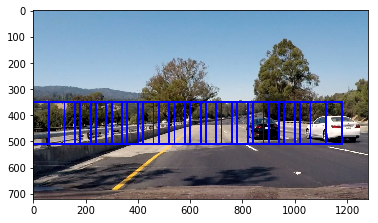

In [12]:
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from feature_extraction import *
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

svc = joblib.load('svc.pkl') 
X_scaler = joblib.load('X_scaler.pkl')

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step):
    
    hot_windows = []
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HLS')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            #if test_prediction == 1:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    
    return hot_windows

def process_frame_subsample(image):
    
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, 720] # Min and max in y to search in slide_window()
    conv='RGB2HLS'
    ystart = 300
    ystop = 720
    cells_per_step = 2
    
    hot_windows = []

    ystart = 380
    ystop = 550
    scale_one = 1.0
    cells_per_step = 1
    hot_windows.extend(find_cars(image, ystart, ystop, scale_one, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
    ystart = 380
    ystop = 600
    scale_two = 1.5
    cells_per_step = 3
    hot_windows.extend(find_cars(image, ystart, ystop, scale_two, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
    ystart = 350
    ystop = 600
    scale_three = 2.5
    cells_per_step = 3
    hot_windows.extend(find_cars(image, ystart, ystop, scale_three, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))

#     heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
#     # Add heat to each box in box list
#     heat = add_heat(heat,hot_windows)

#     # Apply threshold to help remove false positives
#     heat = apply_threshold(heat,2)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
#     labels = label(heatmap)
    draw_img = draw_boxes(np.copy(image), hot_windows)
    
    return draw_img

image = mpimg.imread('C:\\Users\\chrzanowski.dm\\Documents\\carnd\p5\\CarND-Vehicle-Detection\\test_images\\test4.jpg')

draw_img = process_frame_subsample(image)

plt.imshow(draw_img)

# DEMONSTRATE SCANS ON 2 IMAGES

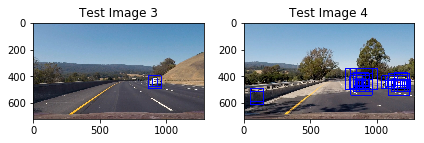

In [7]:
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from feature_extraction import *
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

svc = joblib.load('svc.pkl') 
X_scaler = joblib.load('X_scaler.pkl')

image3 = mpimg.imread('C:\\Users\\chrzanowski.dm\\Documents\\carnd\p5\\CarND-Vehicle-Detection\\test_images\\test3.jpg')
image4 = mpimg.imread('C:\\Users\\chrzanowski.dm\\Documents\\carnd\p5\\CarND-Vehicle-Detection\\test_images\\test4.jpg')

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def process_frame_subsample(image):
    
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, 720] # Min and max in y to search in slide_window()
    conv='RGB2HLS'
    ystart = 300
    ystop = 720
    cells_per_step = 2
    
    hot_windows = []

    scale_one = 1.0
    hot_windows.extend(find_cars(image, ystart, ystop, scale_one, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
    scale_two = 1.5
    hot_windows.extend(find_cars(image, ystart, ystop, scale_two, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
    scale_three = 2.5
    hot_windows.extend(find_cars(image, ystart, ystop, scale_three, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
    scale_four = 4.0
    hot_windows.extend(find_cars(image, ystart, ystop, scale_four, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))

#     heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
#     # Add heat to each box in box list
#     heat = add_heat(heat,hot_windows)

#     # Apply threshold to help remove false positives
#     heat = apply_threshold(heat,2)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
#     labels = label(heatmap)
    draw_img = draw_boxes(np.copy(image), hot_windows)
    
    return draw_img

draw_3 = process_frame_subsample(image3)
draw_4 = process_frame_subsample(image4)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_3)
plt.title('Test Image 3')
plt.subplot(122)
plt.imshow(draw_4)
plt.title('Test Image 4')
fig.tight_layout()

# HEATMAP THRESHOLD DEMO

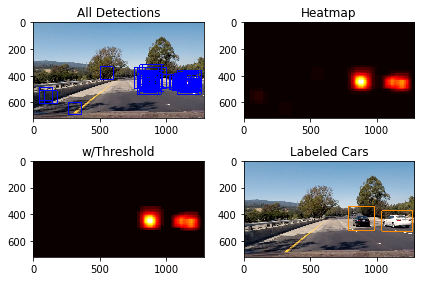

In [29]:
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
#from id_classify import *
from features_scan import *
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

svc = joblib.load('svc.pkl') 
X_scaler = joblib.load('X_scaler.pkl')

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step):
    
    hot_windows = []
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HLS')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    
    return hot_windows

def process_frame_subsample(image):
    
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, 720] # Min and max in y to search in slide_window()
    conv='RGB2HLS'
    ystart = 300
    ystop = 720
    cells_per_step = 2
    
    hot_windows = []

    ystart = 300
    ystop = 720
    scale_one = 1.0
    cells_per_step = 1
    hot_windows.extend(find_cars(image, ystart, ystop, scale_one, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
    ystart = 300
    ystop = 720
    scale_two = 1.5
    cells_per_step = 1
    hot_windows.extend(find_cars(image, ystart, ystop, scale_two, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))
    ystart = 300
    ystop = 720
    scale_three = 2.5
    cells_per_step = 1
    hot_windows.extend(find_cars(image, ystart, ystop, scale_three, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step))

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    all_detects = draw_boxes(np.copy(image),hot_windows)
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat_threshed = apply_threshold(np.copy(heat),3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_threshed, 0, 255)

    #Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return all_detects, heat, heat_threshed, draw_img

image = mpimg.imread('C:\\Users\\chrzanowski.dm\\Documents\\carnd\p5\\CarND-Vehicle-Detection\\test_images\\test4.jpg')

all_detects, heat, heat_threshed, draw_img = process_frame_subsample(image)

fig = plt.figure()
plt.subplot(221)
plt.imshow(all_detects)
plt.title('All Detections')
plt.subplot(222)
plt.imshow(heat, cmap='hot')
plt.title('Heatmap')
plt.subplot(223)
plt.imshow(heat_threshed, cmap='hot')
plt.title('w/Threshold')
plt.subplot(224)
plt.imshow(draw_img)
plt.title('Labeled Cars')
fig.tight_layout()